In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import os
import re
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [145]:
# Set the device for computation (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [146]:
class CNN(nn.Module): # results in accuracy of 73.22%
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.pool(self.leaky_relu(self.conv3(x)))
        x = self.pool(self.leaky_relu(self.conv4(x)))
        x = self.pool(self.leaky_relu(self.conv5(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [147]:
# class CNN(nn.Module): # OVERFITS
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#         self.conv7 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)  # Additional layer
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(1024 * 2 * 2, 1024)  # Updated input size
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 256)
#         self.fc4 = nn.Linear(256, 128)
#         self.fc5 = nn.Linear(128, 64)  # New layer with 64 output neurons
#         self.fc6 = nn.Linear(64, 1)  # Additional layer with 1 output neuron
#         self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

#     def forward(self, x):
#         x = self.pool(self.leaky_relu(self.conv1(x)))
#         x = self.pool(self.leaky_relu(self.conv2(x)))
#         x = self.pool(self.leaky_relu(self.conv3(x)))
#         x = self.pool(self.leaky_relu(self.conv4(x)))
#         x = self.pool(self.leaky_relu(self.conv5(x)))
#         x = self.pool(self.leaky_relu(self.conv6(x)))
#         x = self.leaky_relu(self.conv7(x))  # Additional layer
#         x = x.view(-1, 1024 * 2 * 2)  # Reshape the tensor
#         x = self.leaky_relu(self.fc1(x))
#         x = self.leaky_relu(self.fc2(x))
#         x = self.leaky_relu(self.fc3(x))
#         x = self.leaky_relu(self.fc4(x))
#         x = self.leaky_relu(self.fc5(x))  # Apply activation to new layer
#         x = self.fc6(x)  # Pass through additional layer
#         return x.squeeze(1)  # Squeeze the output tensor



In [148]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(512 * 2 * 2, 2048)
#         self.fc2 = nn.Linear(2048, 1024)
#         self.fc3 = nn.Linear(1024, 512)
#         self.fc4 = nn.Linear(512, 256)
#         self.fc5 = nn.Linear(256, 1)
#         self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)

#     def forward(self, x):
#         x = self.pool(self.leaky_relu(self.conv1(x)))
#         x = self.pool(self.leaky_relu(self.conv2(x)))
#         x = self.pool(self.leaky_relu(self.conv3(x)))
#         x = self.pool(self.leaky_relu(self.conv4(x)))
#         x = self.pool(self.leaky_relu(self.conv5(x)))
#         x = x.view(-1, 512 * 2 * 2)
#         x = self.leaky_relu(self.fc1(x))
#         x = self.leaky_relu(self.fc2(x))
#         x = self.leaky_relu(self.fc3(x))
#         x = self.leaky_relu(self.fc4(x))
#         x = self.fc5(x)
#         return x.squeeze(1)


Epoch 1 - Training Loss: 3379.062720 - Validation Loss: 410.269249 - Learning Rate: 0.001
Epoch 1 completed.
Epoch 2 - Training Loss: 2241.410620 - Validation Loss: 2047.496338 - Learning Rate: 0.001
Epoch 2 completed.
Epoch 3 - Training Loss: 1071.052859 - Validation Loss: 612.289337 - Learning Rate: 0.001
Epoch 3 completed.
Epoch 4 - Training Loss: 623.198019 - Validation Loss: 236.923051 - Learning Rate: 0.001
Epoch 4 completed.
Epoch 5 - Training Loss: 504.651608 - Validation Loss: 217.809458 - Learning Rate: 0.001
Epoch 5 completed.
Epoch 6 - Training Loss: 451.240970 - Validation Loss: 216.996097 - Learning Rate: 0.001
Epoch 6 completed.
Epoch 7 - Training Loss: 460.527063 - Validation Loss: 236.779404 - Learning Rate: 0.001
Epoch 7 completed.
Epoch 8 - Training Loss: 425.311450 - Validation Loss: 263.644596 - Learning Rate: 0.001
Epoch 8 completed.
Epoch 9 - Training Loss: 435.163913 - Validation Loss: 226.345298 - Learning Rate: 0.001
Epoch 9 completed.
Epoch 10 - Training Loss

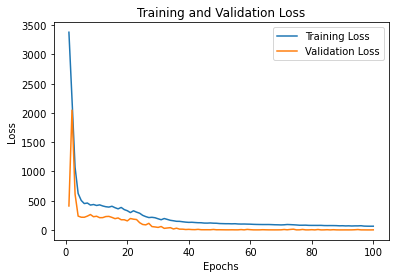

Accuracy for Train_510: 6.67%
Epoch 1 - Training Loss: 2701.188101 - Validation Loss: 1917.528682 - Learning Rate: 0.001
Epoch 1 completed.
Epoch 2 - Training Loss: 858.650496 - Validation Loss: 197.862016 - Learning Rate: 0.001
Epoch 2 completed.
Epoch 3 - Training Loss: 508.211218 - Validation Loss: 197.198435 - Learning Rate: 0.001
Epoch 3 completed.


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [149]:
# Create training dataset
# Set up the data directories
sets = ['Train_510', 'Train_1020', 'Train_2040', 'Train_4080', 'Train_8160', 'Train_10200']
best_train_losses = {}  # Dictionary to store the best training loss for each item
best_val_losses = {}  # Dictionary to store the best validation loss for each item
accuracy = []
for item in sets:
    data_dir = 'Test_Images'
    train_dir = os.path.join(data_dir, item)

    # Define a function to get the labels from the image filenames
    def get_label(filename):
        match = re.search(r'\d+\.?\d*', filename)
        if match:
            return float(match.group())
        else:
            return None

    # Define a list to store the image filenames and labels
    train_data = []

    # Iterate over the training images and add them to the list
    for filename in os.listdir(train_dir):
        label = get_label(filename)
        if label is not None:
            train_data.append([os.path.join(train_dir, filename), label])

    # Convert the list to a dataframe
    train_df = pd.DataFrame(train_data, columns=['filename', 'label'])

    # Save the dataframe to a CSV file
    train_df.to_csv(os.path.join(data_dir, item+'.csv'), index=False)

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = self._load_data(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def _load_data(self, csv_file):
        data = []
        with open(csv_file, 'r') as file:
            lines = file.readlines()
            for line in lines[1:]:
                image_path, label = line.strip().split(',')
                data.append((image_path, float(label)))
        return data

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.4753, 0.4753, 0.4753])
])

for item in sets:
    csv_file = f'Test_Images/{item}.csv'
    image_folder = f'Test_Images/{item}'

    dataset = CustomImageDataset(csv_file, image_folder, transform=transform)

    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    num_epochs = 100
    best_val_loss = float('inf')
    best_learning_rate = None
    patience = 100
    counter = 0
    learning_rate = 0.001

    train_losses = []
    val_losses = []
    epoch_numbers = []
    item_train_losses = []  # List to store training losses for the current item
    item_val_losses = []  # List to store validation losses for the current item

    model = CNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        running_loss = 0.0

        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels.float())

            l1_lambda = 0.01
            l1_regularization = torch.tensor(0.)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            loss += l1_lambda * l1_regularization

            l2_lambda = 0.01
            l2_regularization = torch.tensor(0.)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2)
            loss += l2_lambda * l2_regularization

            running_loss += loss.item()

            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_samples = 0
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels = labels.unsqueeze(1)
                loss = criterion(outputs, labels.float())
                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)

            average_val_loss = val_loss / val_samples

            train_losses.append(running_loss / len(train_loader))
            val_losses.append(average_val_loss)
            item_train_losses.append(running_loss / len(train_loader))
            item_val_losses.append(average_val_loss)

            epoch_numbers.append(epoch + 1)
            print('Epoch %d - Training Loss: %.6f - Validation Loss: %.6f - Learning Rate: %.3f' % (epoch + 1, running_loss / len(train_loader), average_val_loss, learning_rate))

        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            counter = 0
            torch.save(model.state_dict(), f'trained_model_{item}.pt')

        else:
            counter += 1
            if counter >= patience:
                print('No improvement in validation loss. Early stopping.')
                break

        print('Epoch %d completed.' % (epoch + 1))

    best_train_loss = min(item_train_losses)
    best_train_losses[item] = best_train_loss

    best_val_loss = min(item_val_losses)
    best_val_losses[item] = best_val_loss
    # Plotting the losses
    # epochs = range(1, num_epochs + 1)
    plt.plot(epoch_numbers, train_losses, label='Training Loss')
    plt.plot(epoch_numbers, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    plt.savefig(f'loss_plot_{item}.jpeg', format='jpeg')


   
    # # Create a DataFrame to store the predictions
    # predictions_df = pd.DataFrame(columns=['Image', 'Real Value', 'Predicted Value', 'Difference'])

    # # Iterate over the figures in the folder
    # for filename in os.listdir(image_folder):
    #     if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust the file extensions as per your figures
    #         image_path = os.path.join(image_folder, filename)
            
    #         # Load and preprocess the image
    #         image = Image.open(image_path).convert('RGB')
    #         input_tensor = transform(image).unsqueeze(0).to(device)
            
    #         # Extract the real value from the filename
    #         real_value = int(filename.split('_')[1][1:])  # Adjust the splitting pattern to extract the desired value
            
    #         # Make the prediction
    #         with torch.no_grad():
    #             output = model(input_tensor)
    #         predicted_value = output.item()
            
    #         # Calculate the difference between predicted and real value
    #         difference = predicted_value - real_value

    #         # Add the prediction, real value, and difference to the DataFrame
    #         predictions_df = predictions_df.append({'Image': filename, 'Real Value': real_value, 'Predicted Value': predicted_value, 'Difference': difference}, ignore_index=True)

    #     # # Print the predictions table
    #     # print(predictions_df)

    # Create a DataFrame to store the predictions
    predictions_test_df = pd.DataFrame(columns=['Real Value', 'Predicted Value', 'Difference'])

    model = CNN()  # Instantiate a new instance of the CNN class
    model.load_state_dict(torch.load('trained_model_{item}'))  # Load the state dictionary of the pre-trained model

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for tracking correct predictions and total samples
    correct_predictions = 0
    total_samples = 0

    # Define the range for considering a prediction as correct
    max_range = 0.5

    # Iterate over the test data
    for sample in test_loader:

        # Move the input data to the device
        inputs = sample[0].to(device)  # Assuming the input images are the first element in each sample
        labels = sample[1].to(device)  # Assuming the labels are the second element in each sample

        # Forward pass through the model
        with torch.no_grad():
            predicted_values = model(inputs).squeeze().tolist()

        # Get the predicted labels
        predicted_labels = outputs  # Assuming the model output is a single scalar value

        # Calculate the number of correct predictions within the range
        # correct_predictions += ((predicted_labels >= min_range) & (predicted_labels <= max_range) & (labels >= min_range) & (labels <= max_range)).sum().item()
        
    # Iterate over the predicted values and add them to the DataFrame
        for i in range(len(predicted_values)):
            real_value = labels[i].item()
            predicted_value = predicted_values[i]

            # Check if the predicted value is within the desired range (40-70)
            if real_value >= 40 and real_value <= 70:
                # Calculate the difference between predicted and real value
                difference = predicted_value - real_value

                # Add the prediction, real value, and difference to the DataFrame
                predictions_test_df = predictions_test_df.append({'Real Value': real_value, 'Predicted Value': predicted_value, 'Difference': difference}, ignore_index=True)

                # Check if the prediction is correct within the desired range
                if abs(real_value - predicted_value) <= max_range:
                    correct_predictions += 1


    # Calculate the accuracy
    accuracy_value = correct_predictions / (len(predictions_test_df)-1)
    accuracy.append(accuracy_value)

    # # Print the predictions DataFrame
    # print(predictions_test_df)

    # Print the accuracy
    print(f"Accuracy for {item}: {accuracy_value * 100:.2f}%")
    
for item in sets:
    print(f"Item: {item}")
    print(f"Best Validation Loss: {best_val_losses[item]}")
    print(f"Best Training Loss: {best_train_losses[item]}")
    print(f"Accuracy for {item}: {accuracy_value * 100:.2f}%")

In [ ]:
for i, item in enumerate(sets):
    print(f"Item: {item}")
    print(f"Best Validation Loss: {best_val_losses[item]}")
    print(f"Best Training Loss: {best_train_losses[item]}")
    print(f"Accuracy for {item}: {accuracy[i] * 100:.2f}%")

Item: Train_510
Best Validation Loss: 213.3171792123832
Best Training Loss: 344.830419921875
Accuracy for Train_510: 0.00%
Item: Train_1020
Best Validation Loss: 2.5618433928957174
Best Training Loss: 65.54328365325928
Accuracy for Train_1020: 3.15%
Item: Train_2040


KeyError: 'Train_2040'

ValueError: x and y must be the same size

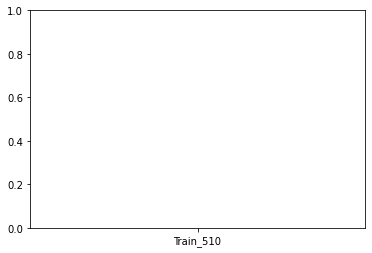

In [ ]:
plt.scatter(sets, accuracy)
plt.xlabel('Data set size')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Sets')
plt.xticks(rotation=45)  # Rotate the x-axis labels if needed
plt.show()

In [ ]:
# Prepare data for scatter plot
x_values = sets
y_val_losses = [best_val_losses[item] for item in sets]
y_train_losses = [best_train_losses[item] for item in sets]

# Create scatter plot
plt.scatter(x_values, y_val_losses, label='Best Validation Loss')
plt.scatter(x_values, y_train_losses, label='Best Training Loss')

# Set labels and title
plt.xlabel('Sets')
plt.ylabel('Loss')
plt.title('Best Validation and Training Loss per set')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Save the plot
plt.savefig('Best_losses_per_set.jpeg', format='jpeg')

KeyError: 'Train_2040'